In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from os import listdir, getcwd, chdir
from os.path import isfile, join

from diff_classifier.features import alpha_calc, unmask_track
from diff_predictor.utils import plot_msd_comparisons, plot_individual_msds, plot_particles_in_frame

import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy.ma as ma
import lmfit

In [2]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


# Age Data

In [3]:
age_msd_path = workbookDir + '/raw_data_age/'
age_feature_path = workbookDir + '/data/raw_data_age/'

age_msd_filelist = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P70' in f]
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'features_P70' in f]

## Scipy curvefit

In [9]:
perr_alph = []
perr_dcoef = []

for i in range(len(age_msd_filelist)):

    
    msd_df = pd.read_csv(age_msd_path + age_msd_filelist[i])
    trackids = msd_df['Track_ID'].unique()
    partcount = trackids.shape[0]
    for particle in range(0, partcount):

        single_track_masked = msd_df.loc[msd_df['Track_ID'] == trackids[particle]].sort_values(['Track_ID', 'Frame'], ascending=[1,1]).reset_index(drop=True)
        single_track = unmask_track(single_track_masked)
        xpos = single_track['MSDs']
        ypos = single_track['Frame']

        def msd_alpha(xpos, alph, dcoef):
                return 4*dcoef*(xpos**alph)

        try:
            popt, pcov = curve_fit(msd_alpha, xpos, ypos)
            alph = popt[0]
            dcoef = popt[1]
            perr = np.sqrt(np.diag(pcov))
            perr_alph.append(perr[0])
            perr_dcoef.append(perr[1])
        except RuntimeError:
            print('Optimal parameters not found. Print NaN instead.')
            alph = np.nan
            dcoef = np.nan
        

TypeError: curve_fit() missing 1 required positional argument: 'ydata'

## LMFIT

In [8]:
perr_alph = []
perr_dcoef = []

for i in range(len(age_msd_filelist)):

    
    msd_df = pd.read_csv(age_msd_path + age_msd_filelist[i])
    trackids = msd_df['Track_ID'].unique()
    partcount = trackids.shape[0]
    for particle in range(0, partcount):

        single_track_masked = msd_df.loc[msd_df['Track_ID'] == trackids[particle]].sort_values(['Track_ID', 'Frame'], ascending=[1,1]).reset_index(drop=True)
        single_track = unmask_track(single_track_masked)
        xpos = single_track['MSDs']
        ypos = single_track['Frame']

        def msd_alpha(xpos, alph, dcoef):
                return 4*dcoef*(xpos**alph) #math.pow

        msd_model = lmfit.Model(msd_alpha)
        msd_model.set_param_hint('alph', value=1.0, min=0.00001, max=13)
        #msd_model.set_param_hint('dcoef', value=1.0, min=0, max=10)
        #params = msd_model.make_params(alph=1, dcoef=1)
        

        try:
            model_result = msd_model.fit(ypos, xpos=xpos, alph=1, dcoef=1)
            print(model_result.model_pars)
            
        except RuntimeError:
        #except ValueError:
            print('Optimal parameters not found. Print NaN instead.')
            alph = np.nan
            dcoef = np.nan

AttributeError: 'ModelResult' object has no attribute 'model_pars'

(array([3.135e+03, 1.605e+03, 9.660e+02, 4.490e+02, 1.800e+02, 6.300e+01,
        2.500e+01, 1.000e+01, 5.000e+00, 1.000e+00]),
 array([0.00148792, 0.11269693, 0.22390594, 0.33511495, 0.44632397,
        0.55753298, 0.66874199, 0.779951  , 0.89116001, 1.00236902,
        1.11357803]),
 <BarContainer object of 10 artists>)

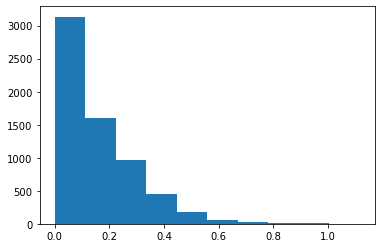

In [62]:
perr_alph_arr = np.array(perr_alph)
perr_alph_arr = perr_alph_arr[perr_alph_arr != np.inf]
plt.hist(perr_alph_arr)

(array([5.83e+03, 3.25e+02, 1.89e+02, 7.30e+01, 1.20e+01, 8.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([2.07907946e-06, 1.09840294e+00, 2.19680379e+00, 3.29520465e+00,
        4.39360550e+00, 5.49200636e+00, 6.59040722e+00, 7.68880807e+00,
        8.78720893e+00, 9.88560978e+00, 1.09840106e+01]),
 <BarContainer object of 10 artists>)

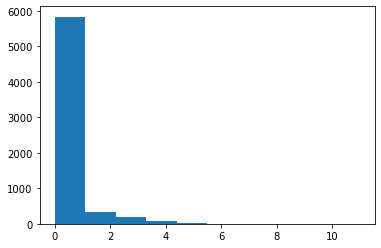

In [65]:
perr_dcoef_arr = np.array(perr_dcoef)
perr_dcoef_arr = perr_dcoef_arr[perr_dcoef_arr != np.inf]
plt.hist(perr_dcoef_arr)

In [25]:
popt

array([0.48696266, 3.23778483])

In [18]:
alpha, coef = alpha_calc(single_track)